#### 3. Using midsize (n=5000) dataset from mongoDB, better for tsne. Scikit-learn for analysis. Apply what was done for small_analysis.

In [1]:
from pymongo import MongoClient
client = MongoClient(port=12345) # this is the port set by the SSH tunnel
db = client.pubmed_ad # database name

In [2]:
db.alz.count()

130672

In [3]:
# create lists containing BOTH abstracts (AB) or titles (TI)
cursor = db.alz.find(
    { 'AB': { '$ne': None }, 'TI': {'$ne': None}},
    { 'AB': 1, '_id': 0, 'TI': 1 }
).limit(5000) 

docs = list(cursor)

In [4]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [5]:
# all the abstracts
docs_ab = []

for i, abstract in enumerate(d['AB'] for d in docs): 
    docs_ab.append(abstract)

In [6]:
len(docs_ab)

5000

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

pipe = [
    ('tfidf', TfidfVectorizer(stop_words="english", 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", 
                        min_df=3)),
    ('lsa', TruncatedSVD(n_components=300)),
    ('norm', Normalizer())
]
pipe = Pipeline(pipe)

In [8]:
dtm_svd = pipe.fit_transform(docs_ab)

In [9]:
dtm_svd_df = pd.DataFrame(dtm_svd)

In [10]:
km = KMeans(n_clusters=10)
km.fit(dtm_svd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
# in this pkl file, km was fit on full datasest (115K+ abstracts)
from sklearn.externals import joblib
joblib.dump(km, 'fletcher.pkl') 

In [11]:
# centroids
mu_digits_ab = km.cluster_centers_

In [ ]:
# what are the labels? Do not confuse the label with the digit prediction
temp = (pd.Series(km.labels_))
print(sorted(temp.unique()))
print(temp.shape)

In [12]:
clusters = km.fit_predict(dtm_svd)

from collections import Counter

Counter(clusters)

Counter({0: 598,
         1: 350,
         2: 208,
         3: 454,
         4: 159,
         5: 714,
         6: 201,
         7: 343,
         8: 832,
         9: 1141})

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer

print('Top Terms Per Cluster')
original_space_centroids = pipe.steps[1][1].inverse_transform(mu_digits_ab)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = pipe.steps[0][1].get_feature_names()
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top Terms Per Cluster
Cluster 0: ache compounds inhibitors activity inhibition compound inhibitory derivatives acetylcholinesterase synthesized
Cluster 1: app abeta secretase ad amyloid protein mice beta precursor processing
Cluster 2: cognitive patients mci ad memory impairment decline group participants dementia
Cluster 3: mice ad memory expression induced rats brain abeta hippocampus levels
Cluster 4: ad csf patients risk disease biomarkers apoe clinical studies tau
Cluster 5: diseases disease cells brain neurodegenerative protein cell disorders proteins alzheimer
Cluster 6: abeta amyloid aggregation ad beta peptide peptides oligomers formation fibrils
Cluster 7: dementia care patients caregivers risk ci people health use disease
Cluster 8: brain ad connectivity imaging mri method mci patients network pet
Cluster 9: tau ad protein pathology tauopathies csf phosphorylation brain mice disease


In [14]:
from sklearn.manifold import TSNE
dtm_svd_vis = TSNE().fit_transform(dtm_svd_df)
dtm_svd_vis_df = pd.DataFrame(dtm_svd_vis)

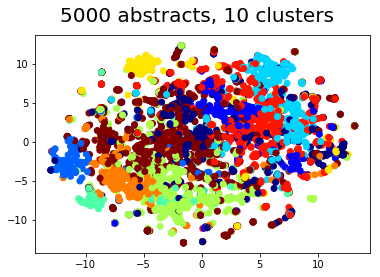

In [15]:
plt.scatter(dtm_svd_vis_df.iloc[: , :1], dtm_svd_vis_df.iloc[: , -1:], c = clusters, cmap=plt.cm.get_cmap("jet", 10))
plt.suptitle('5000 abstracts, 10 clusters', fontsize=20)

In [16]:
def print_topic_top_words(pipe, n_topics=10, n_words=10):
    cv = pipe.steps[0][1]
    model = pipe.steps[1][1]
    feature_names = cv.get_feature_names()
    
    for topic_num in range(n_topics):
        topic_mat = model.components_[topic_num]
        
        print('Topic {}:'.format(topic_num + 1).center(80))
        
        topic_values = sorted(zip(topic_mat, feature_names), 
                              reverse=True)[:n_words]
        print(' '.join([y for x,y in topic_values]))
        print('-'*80)
        
print_topic_top_words(pipe)

                                    Topic 1:                                    
ad abeta disease tau cognitive brain patients amyloid dementia mice
--------------------------------------------------------------------------------
                                    Topic 2:                                    
dementia mci patients cognitive risk mild participants impairment clinical ci
--------------------------------------------------------------------------------
                                    Topic 3:                                    
tau csf abeta ad amyloid pet pathology mci biomarkers levels
--------------------------------------------------------------------------------
                                    Topic 4:                                    
tau diseases neurodegenerative csf disorders disease review parkinson protein pd
--------------------------------------------------------------------------------
                                    Topic 5:                    

#### 5000 titles

In [17]:
docs_ti = []

for i, title in enumerate(d['TI'] for d in docs): 
    docs_ti.append(title)
    
len(docs_ti)

5000

In [18]:
dtm2_svd = pipe.fit_transform(docs_ti)
dtm2_svd_df = pd.DataFrame(dtm2_svd)

In [19]:
km2 = KMeans(n_clusters=10)
km2.fit(dtm2_svd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [20]:
clusters_ti = km2.fit_predict(dtm2_svd)

Counter(clusters_ti)

Counter({0: 1628,
         1: 136,
         2: 298,
         3: 244,
         4: 1246,
         5: 458,
         6: 351,
         7: 199,
         8: 254,
         9: 186})

In [21]:
mu_digits_ti = km2.cluster_centers_

In [22]:
print('Top Terms Per Cluster')
original_space_centroids = pipe.steps[1][1].inverse_transform(mu_digits_ti)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = pipe.steps[0][1].get_feature_names()
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top Terms Per Cluster
Cluster 0: brain study mice human analysis activity neurodegeneration cognitive receptor inhibitors
Cluster 1: review systematic meta dementia analysis disease alzheimer cognitive literature patients
Cluster 2: cognitive impairment mild alzheimer disease patients amnestic decline memory study
Cluster 3: induced cells apoptosis attenuates stress abeta rats oxidative mice sh
Cluster 4: disease alzheimer patients risk study biomarkers early brain associated treatment
Cluster 5: amyloid beta protein aggregation peptide precursor alzheimer disease induced oligomers
Cluster 6: dementia alzheimer study frontotemporal patients risk lewy care disease bodies
Cluster 7: neurodegenerative diseases disorders therapeutic role disease neurological brain parkinson potential
Cluster 8: model mouse alzheimer disease transgenic rat effects cognitive memory brain
Cluster 9: tau pathology alzheimer disease phosphorylation protein mice hyperphosphorylation pet tauopathy


In [23]:
dtm2_svd_vis = TSNE().fit_transform(dtm2_svd_df)
dtm2_svd_vis_df = pd.DataFrame(dtm2_svd_vis)

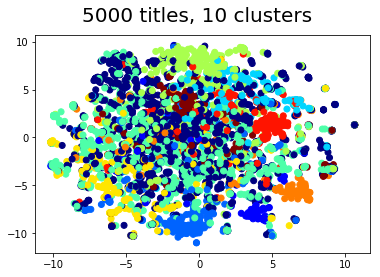

In [24]:
plt.scatter(dtm2_svd_vis_df.iloc[: , :1], dtm2_svd_vis_df.iloc[: , -1:], c = clusters_ti, cmap=plt.cm.get_cmap("jet", 10))
plt.suptitle('5000 titles, 10 clusters', fontsize=20)

In [25]:
print_topic_top_words(pipe)

                                    Topic 1:                                    
disease alzheimer cognitive amyloid impairment mild model patients beta brain
--------------------------------------------------------------------------------
                                    Topic 2:                                    
cognitive impairment mild dementia patients decline study amnestic risk review
--------------------------------------------------------------------------------
                                    Topic 3:                                    
disease alzheimer biomarkers therapeutic onset potential treatment parkinson diagnosis therapy
--------------------------------------------------------------------------------
                                    Topic 4:                                    
neurodegenerative diseases dementia review disorders systematic brain role therapeutic analysis
--------------------------------------------------------------------------------
    